# City Location Election:

In [53]:
import pandas as pd
import requests
import os
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from pymongo import MongoClient
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import folium
import numpy as np
from API import *

**Importar database de Companies:**

In [26]:
dbName = "companies"
mongodbURL = f"mongodb://localhost/{dbName}"
print(mongodbURL)
client = MongoClient(mongodbURL, connectTimeoutMS=2000,serverSelectionTimeoutMS=2000)
db = client.get_database()

mongodb://localhost/companies


**Filtro dataset por empresas de gaming:**

In [27]:
cursor=db.companies.find({"category_code":"games_video"},{"offices":1,"name":1,"total_money_raised":1,"founded_year":1})
games_data=pd.DataFrame(cursor)
games_data=games_data.explode("offices") # separar en diferentes rows las companies que tengan más de 1 office
games_data

,_id,name,founded_year,total_money_raised,offices
0,52cdef7c4bab8bd675297d92,Flektor,NaN,$0,"{'description': None, 'address1': '8536 Nation..."
1,52cdef7c4bab8bd675297d99,Lala,NaN,$44.2M,"{'description': 'Lala Headquarters', 'address1..."
2,52cdef7c4bab8bd675297d9d,Joost,2006.0,$45M,"{'description': '', 'address1': '100 5th Ave F..."
3,52cdef7c4bab8bd675297da0,Babelgum,2007.0,$13.2M,"{'description': '', 'address1': '', 'address2'..."
4,52cdef7c4bab8bd675297daa,Sparter,2007.0,$0,"{'description': None, 'address1': None, 'addre..."
...,...,...,...,...,...
1079,52cdef7f4bab8bd67529c676,Rev Media,2008.0,$0,"{'description': 'HQ', 'address1': '', 'address..."
1080,52cdef7f4bab8bd67529c694,Fictionaut,2008.0,$0,"{'description': 'New York', 'address1': '32-14..."
1080,52cdef7f4bab8bd67529c694,Fictionaut,2008.0,$0,"{'description': 'Houston', 'address1': '2208 C..."
1081,52cdef7f4bab8bd67529c6b6,Tiny Speck,2009.0,$17.2M,"{'description': '', 'address1': '163 Hastings ..."


**Separamos el contenido de la columna offices por Country y City**

In [28]:
def officeCity(row):
    office = row.offices
    if type(office) == dict:
        if 'country_code' in office and 'city' in office:
            return ({"name":row["name"], "Country":office["country_code"],"City":office["city"],"Coordinates":[office["latitude"],office["longitude"]]},"success")
        else:
            return (None,"No country in office dict")
    return (None)

In [29]:
cleaned_offices_games = games_data.apply(officeCity,axis=1,result_type="expand")
cleaned_offices_games.columns = ["office","clean_state"]

In [30]:
data_games = pd.concat([games_data,cleaned_offices_games], axis=1)
data_games = data_games[["name","total_money_raised","founded_year","office","clean_state"]]

In [31]:
data_games.isnull().sum()

name                    0
total_money_raised      0
founded_year          198
office                244
clean_state           244
dtype: int64

In [32]:
data_games=data_games.dropna(subset=["office","clean_state"])
data_games.isnull().sum()

name                    0
total_money_raised      0
founded_year          138
office                  0
clean_state             0
dtype: int64

In [33]:
data_games.clean_state.value_counts()
data_games=data_games.drop(columns="clean_state")
data_games.head()

,name,total_money_raised,founded_year,office
0,Flektor,$0,NaN,"{'name': 'Flektor', 'Country': 'USA', 'City': ..."
1,Lala,$44.2M,NaN,"{'name': 'Lala', 'Country': 'USA', 'City': 'Pa..."
2,Joost,$45M,2006.0,"{'name': 'Joost', 'Country': 'USA', 'City': 'N..."
3,Babelgum,$13.2M,2007.0,"{'name': 'Babelgum', 'Country': 'GBR', 'City':..."
4,Sparter,$0,2007.0,"{'name': 'Sparter', 'Country': 'USA', 'City': ..."


In [34]:
office_list=list(data_games["office"])
offices_columns=json_normalize(office_list,max_level=1)
offices_columns.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,Country,City,Coordinates
0,Flektor,USA,Culver City,"[34.025958, -118.379768]"
1,Lala,USA,Palo Alto,"[37.451151, -122.154369]"
2,Joost,USA,New York,"[40.7464969, -74.0094471]"
3,Babelgum,GBR,London,"[53.344104, -6.267494]"
4,Sparter,USA,None,"[37.09024, -95.712891]"


In [35]:
gaming_companies_data=pd.merge(data_games,offices_columns,on="name")
gaming_companies_data.head()

,name,total_money_raised,founded_year,office,Country,City,Coordinates
0,Flektor,$0,NaN,"{'name': 'Flektor', 'Country': 'USA', 'City': ...",USA,Culver City,"[34.025958, -118.379768]"
1,Lala,$44.2M,NaN,"{'name': 'Lala', 'Country': 'USA', 'City': 'Pa...",USA,Palo Alto,"[37.451151, -122.154369]"
2,Joost,$45M,2006.0,"{'name': 'Joost', 'Country': 'USA', 'City': 'N...",USA,New York,"[40.7464969, -74.0094471]"
3,Babelgum,$13.2M,2007.0,"{'name': 'Babelgum', 'Country': 'GBR', 'City':...",GBR,London,"[53.344104, -6.267494]"
4,Sparter,$0,2007.0,"{'name': 'Sparter', 'Country': 'USA', 'City': ...",USA,None,"[37.09024, -95.712891]"


**Creamos columnas Latitude y Longitude:**

In [36]:
gaming_companies_data["Latitude"]=[x[0]for x in gaming_companies_data["Coordinates"]]
gaming_companies_data["Longitude"]=[x[1]for x in gaming_companies_data["Coordinates"]]
gaming_companies_data.head()

,name,total_money_raised,founded_year,office,Country,City,Coordinates,Latitude,Longitude
0,Flektor,$0,NaN,"{'name': 'Flektor', 'Country': 'USA', 'City': ...",USA,Culver City,"[34.025958, -118.379768]",34.025958,-118.379768
1,Lala,$44.2M,NaN,"{'name': 'Lala', 'Country': 'USA', 'City': 'Pa...",USA,Palo Alto,"[37.451151, -122.154369]",37.451151,-122.154369
2,Joost,$45M,2006.0,"{'name': 'Joost', 'Country': 'USA', 'City': 'N...",USA,New York,"[40.7464969, -74.0094471]",40.746497,-74.009447
3,Babelgum,$13.2M,2007.0,"{'name': 'Babelgum', 'Country': 'GBR', 'City':...",GBR,London,"[53.344104, -6.267494]",53.344104,-6.267494
4,Sparter,$0,2007.0,"{'name': 'Sparter', 'Country': 'USA', 'City': ...",USA,None,"[37.09024, -95.712891]",37.090240,-95.712891


In [37]:
gaming_companies_data=gaming_companies_data.drop(columns="office")
gaming_companies_data=gaming_companies_data.rename(columns={"name":"Name","Country":"Country_office","City":"City_office","Coordinates":"Coordinates_office"})

In [38]:
gaming_companies_data.head()

,Name,total_money_raised,founded_year,Country_office,City_office,Coordinates_office,Latitude,Longitude
0,Flektor,$0,NaN,USA,Culver City,"[34.025958, -118.379768]",34.025958,-118.379768
1,Lala,$44.2M,NaN,USA,Palo Alto,"[37.451151, -122.154369]",37.451151,-122.154369
2,Joost,$45M,2006.0,USA,New York,"[40.7464969, -74.0094471]",40.746497,-74.009447
3,Babelgum,$13.2M,2007.0,GBR,London,"[53.344104, -6.267494]",53.344104,-6.267494
4,Sparter,$0,2007.0,USA,None,"[37.09024, -95.712891]",37.090240,-95.712891


In [39]:
gaming_companies_data.to_json("OUTPUT/gaming_companies.json",orient="records")

**Ver en que paises y cuidades abren más oficinas las gaming companies:**

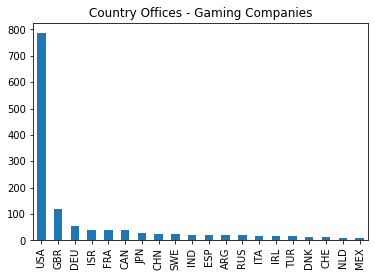

In [40]:
gaming_countries=gaming_companies_data["Country_office"].value_counts().head(20)
gaming_countries.plot.bar(title="Country Offices - Gaming Companies")

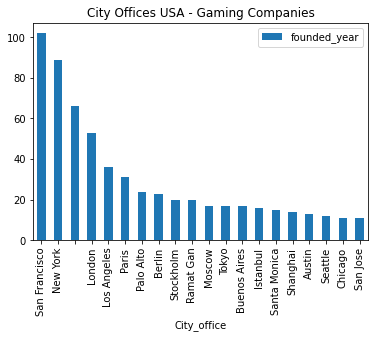

In [41]:
filtered=gaming_companies_data[(gaming_companies_data["Country_office"]=="USA")]
grouped=gaming_companies_data.groupby("City_office").agg({"founded_year":"count"})
results=grouped.sort_values("founded_year",ascending=False).head(20)
results.plot.bar(title="City Offices USA - Gaming Companies")

### Web Scrapping Top USA Cities for gamers:

In [42]:
#Web Scrapping to look for top cities for gamers USA:
url= "http://blog.gisuser.com/2019/06/05/report-on-2019s-best-cities-for-gamers/"
html=requests.get(url)
print(html)
soup=BeautifulSoup(html.text)
gamers=soup.select("table")
gamers=gamers[0]
lineas = gamers.find('tbody').find_all("tr")[1:]

<Response [200]>


In [43]:
def WebScrapping(tag):
    td = tag.find_all("td")
    return {
        "puesto": int(td[0].text),
        "cuidad": td[1].text
    }

WebScrapping(lineas[0])

{'puesto': 1, 'cuidad': 'Seattle, WA'}

In [44]:
top_cities=list(map(WebScrapping, lineas))
top_cities

[{'puesto': 1, 'cuidad': 'Seattle, WA'},
 {'puesto': 2, 'cuidad': 'Irvine, CA'},
 {'puesto': 3, 'cuidad': 'Los Angeles, CA'},
 {'puesto': 4, 'cuidad': 'Orlando, FL'},
 {'puesto': 5, 'cuidad': 'Atlanta, GA'},
 {'puesto': 6, 'cuidad': 'New York, NY'},
 {'puesto': 7, 'cuidad': 'San Jose, CA'},
 {'puesto': 8, 'cuidad': 'San Francisco, CA'},
 {'puesto': 9, 'cuidad': 'Austin, TX'},
 {'puesto': 10, 'cuidad': 'Raleigh, NC'}]

**Si tenemos en cuenta la lista de Top cities para los gamers en USA, la cuidad de Seattle es la cuidad con más gamers en USA, por lo que vamos a explorar las opciones de abrir una office ahi.**

*Para ello, vamos a comprobar cuantas companies tienen oficce en Seattle:*

In [45]:
data=db.gaming_companies.find({"City_office":"Seattle"},{"Name":1,"Coordinates_office":1,"Latitude":1,"Longitude":1})
games_seattle_offices=pd.DataFrame(data)
print(games_seattle_offices.shape)
games_seattle_offices.head()

(14, 5)


,_id,Name,Coordinates_office,Latitude,Longitude
0,5e9c7f2f612f4c7097c01c64,iLike,"[47.615313, -122.323408]",47.615313,-122.323408
1,5e9c7f2f612f4c7097c01c71,BuddyTV,"[47.61968, -122.356756]",47.619680,-122.356756
2,5e9c7f2f612f4c7097c01ca7,MediaPops,"[47.611012, -122.333523]",47.611012,-122.333523
3,5e9c7f2f612f4c7097c01cad,FlowPlay,"[47.6015315, -122.335943]",47.601532,-122.335943
4,5e9c7f2f612f4c7097c01cba,Tioti,"[47.733603, -122.355579]",47.733603,-122.355579


**Visualizar la localización de cada una de las oficinas con respecto a un punto determinado. En este caso, he cogido como referencia un punto céntrico de la cuidad Seattle Downtown:**

In [47]:
downtown = "Downtown Seattle"
geocode(downtown)

<Response [200]>


{'coordinates': [-122.33279, 47.62405]}

In [48]:
seattle = folium.Map(
    location=[47.61186, -122.33581],
    zoom_start=12,
    tiles='Stamen Terrain'
)

def AddFolium (latitude,longitud):
    folium.Marker(
    location=[latitude,longitud],
    popup=folium.Popup(max_width=450)
    ).add_to(seattle)

 
punto1=AddFolium(games_seattle_offices["Latitude"][0],games_seattle_offices["Longitude"][0])
punto2=AddFolium(games_seattle_offices["Latitude"][1],games_seattle_offices["Longitude"][1])
punto3=AddFolium(games_seattle_offices["Latitude"][2],games_seattle_offices["Longitude"][2])
punto4=AddFolium(games_seattle_offices["Latitude"][3],games_seattle_offices["Longitude"][3])
punto5=AddFolium(games_seattle_offices["Latitude"][4],games_seattle_offices["Longitude"][4])
punto6=AddFolium(games_seattle_offices["Latitude"][5],games_seattle_offices["Longitude"][5])
punto7=AddFolium(games_seattle_offices["Latitude"][6],games_seattle_offices["Longitude"][6])
punto8=AddFolium(games_seattle_offices["Latitude"][7],games_seattle_offices["Longitude"][7])
punto9=AddFolium(games_seattle_offices["Latitude"][8],games_seattle_offices["Longitude"][8])
punto10=AddFolium(games_seattle_offices["Latitude"][9],games_seattle_offices["Longitude"][9])
punto11=AddFolium(games_seattle_offices["Latitude"][10],games_seattle_offices["Longitude"][10])
punto12=AddFolium(games_seattle_offices["Latitude"][11],games_seattle_offices["Longitude"][11])
punto13=AddFolium(games_seattle_offices["Latitude"][12],games_seattle_offices["Longitude"][12])
punto14=AddFolium(games_seattle_offices["Latitude"][13],games_seattle_offices["Longitude"][13])

In [54]:
display(seattle)

In [55]:
seattle.save("GamingCompanies_Seattle.html")